In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, plot_roc_curve, accuracy_score, f1_score, plot_confusion_matrix

from xgboost import XGBClassifier

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import utils as ut

In [2]:
data = pd.read_csv('data/training_set_features.csv')
labels = pd.read_csv('data/training_set_labels.csv')

In [3]:
# The features in this dataset
# You are provided a dataset with 36 columns. The first column respondent_id is a unique and random identifier. The remaining 35 features are described below.

# For all binary variables: 0 = No; 1 = Yes.

# h1n1_concern - Level of concern about the H1N1 flu.
# 0 = Not at all concerned; 1 = Not very concerned; 2 = Somewhat concerned; 3 = Very concerned.
# h1n1_knowledge - Level of knowledge about H1N1 flu.
# 0 = No knowledge; 1 = A little knowledge; 2 = A lot of knowledge.
# behavioral_antiviral_meds - Has taken antiviral medications. (binary)
# behavioral_avoidance - Has avoided close contact with others with flu-like symptoms. (binary)
# behavioral_face_mask - Has bought a face mask. (binary)
# behavioral_wash_hands - Has frequently washed hands or used hand sanitizer. (binary)
# behavioral_large_gatherings - Has reduced time at large gatherings. (binary)
# behavioral_outside_home - Has reduced contact with people outside of own household. (binary)
# behavioral_touch_face - Has avoided touching eyes, nose, or mouth. (binary)
# doctor_recc_h1n1 - H1N1 flu vaccine was recommended by doctor. (binary)
# doctor_recc_seasonal - Seasonal flu vaccine was recommended by doctor. (binary)
# chronic_med_condition - Has any of the following chronic medical conditions: asthma or an other lung condition, diabetes, a heart condition, a kidney condition, sickle cell anemia or other anemia, a neurological or neuromuscular condition, a liver condition, or a weakened immune system caused by a chronic illness or by medicines taken for a chronic illness. (binary)
# child_under_6_months - Has regular close contact with a child under the age of six months. (binary)
# health_worker - Is a healthcare worker. (binary)
# health_insurance - Has health insurance. (binary)
# opinion_h1n1_vacc_effective - Respondent's opinion about H1N1 vaccine effectiveness.
# 1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.
# opinion_h1n1_risk - Respondent's opinion about risk of getting sick with H1N1 flu without vaccine.
# 1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.
# opinion_h1n1_sick_from_vacc - Respondent's worry of getting sick from taking H1N1 vaccine.
# 1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.
# opinion_seas_vacc_effective - Respondent's opinion about seasonal flu vaccine effectiveness.
# 1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.
# opinion_seas_risk - Respondent's opinion about risk of getting sick with seasonal flu without vaccine.
# 1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.
# opinion_seas_sick_from_vacc - Respondent's worry of getting sick from taking seasonal flu vaccine.
# 1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.
# age_group - Age group of respondent.
# education - Self-reported education level.
# race - Race of respondent.
# sex - Sex of respondent.
# income_poverty - Household annual income of respondent with respect to 2008 Census poverty thresholds.
# marital_status - Marital status of respondent.
# rent_or_own - Housing situation of respondent.
# employment_status - Employment status of respondent.
# hhs_geo_region - Respondent's residence using a 10-region geographic classification defined by the U.S. Dept. of Health and Human Services. Values are represented as short random character strings.
# census_msa - Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census.
# household_adults - Number of other adults in household, top-coded to 3.
# household_children - Number of children in household, top-coded to 3.
# employment_industry - Type of industry respondent is employed in. Values are represented as short random character strings.
# employment_occupation - Type of occupation of respondent. Values are represented as short random character strings.

In [4]:
# train test split
# deal with nulls
# look for patterns in the nulls
# no numeric columns so no need to look for outliers
# one hot encode categorical columns
# scale
# vanilla model
# check for multicolinearity (or variables that are not independent)
# solve class imbalance problems?? - no need
# look for interactions? - marital status and sex, also employment status and sex
# logistic regression!
# -->can experiment with the regularization parameter (C)
# eval measure should be ROC-AUC (for competition anyway)
# try a tree!  a forest!
# try ensemble method?  XGBoost?
# pipeline!
# use confusion matrices to evaluate
# what can be learned from coefficients

# does health worker data match employment data?


In [5]:
# use k fold cross validation to make sure you're not overfitting to this test set
# try all combos for other models, use gridsearch
# steal and use Lindsey's evaluate function if you want - Topic 32 Pipelines plus phase 3 wrap up
# it includes a confusion matrix
# if doing a logreg, look at week 20 optional challenge

In [6]:

# look at practice notebook from week 22
# shows steps of building a simple model, testing models, iterating, choosing a model
# try to do 3 model types

# include all detail on "why did I make that decision?"  "why did I do that next step?"
# especially: why did you decide to use this model?


In [7]:
labels

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0
...,...,...,...
26702,26702,0,0
26703,26703,0,0
26704,26704,0,1
26705,26705,0,0


In [8]:
# define X (predictors) and y (target)
# keep only predictors which a health management organization would have on file
# use seasonal flu vaccine outcome as target (disregard H1N1)

X = data.drop(columns=['h1n1_concern',
                       'h1n1_knowledge',
                       'behavioral_antiviral_meds',
                       'behavioral_avoidance',
                       'behavioral_face_mask',
                       'behavioral_wash_hands',
                       'behavioral_large_gatherings',
                       'behavioral_outside_home',
                       'behavioral_touch_face',
                       'doctor_recc_h1n1',
                       'child_under_6_months',
                       'opinion_h1n1_vacc_effective',
                       'opinion_h1n1_risk',
                       'opinion_h1n1_sick_from_vacc',
                       'opinion_h1n1_sick_from_vacc',
                       'opinion_seas_vacc_effective',
                       'opinion_seas_risk',
                       'opinion_seas_sick_from_vacc',
                       'education',
                       'income_poverty',
                       'rent_or_own',
                       'household_adults',
                       'household_children'])

y = labels['seasonal_vaccine']

In [9]:
X

,respondent_id,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,age_group,race,sex,marital_status,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
0,0,0.00000,0.00000,0.00000,1.00000,55 - 64 Years,White,Female,Not Married,Not in Labor Force,oxchjgsf,Non-MSA,NaN,NaN
1,1,0.00000,0.00000,0.00000,1.00000,35 - 44 Years,White,Male,Not Married,Employed,bhuqouqj,"MSA, Not Principle City",pxcmvdjn,xgwztkwe
2,2,nan,1.00000,0.00000,nan,18 - 34 Years,White,Male,Not Married,Employed,qufhixun,"MSA, Not Principle City",rucpziij,xtkaffoo
3,3,1.00000,1.00000,0.00000,nan,65+ Years,White,Female,Not Married,Not in Labor Force,lrircsnp,"MSA, Principle City",NaN,NaN
4,4,0.00000,0.00000,0.00000,nan,45 - 54 Years,White,Female,Married,Employed,qufhixun,"MSA, Not Principle City",wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,0.00000,0.00000,0.00000,nan,65+ Years,White,Female,Not Married,Not in Labor Force,qufhixun,Non-MSA,NaN,NaN
26703,26703,1.00000,0.00000,1.00000,1.00000,18 - 34 Years,White,Male,Not Married,Employed,lzgpxyit,"MSA, Principle City",fcxhlnwr,cmhcxjea
26704,26704,0.00000,0.00000,0.00000,nan,55 - 64 Years,White,Female,Not Married,NaN,lzgpxyit,"MSA, Not Principle City",NaN,NaN
26705,26705,0.00000,0.00000,0.00000,0.00000,18 - 34 Years,Hispanic,Female,Married,Employed,lrircsnp,Non-MSA,fcxhlnwr,haliazsg


In [10]:
# eliminate id column, which is the same as index number

X.drop(columns='respondent_id', inplace=True)
X

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,age_group,race,sex,marital_status,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
0,0.00000,0.00000,0.00000,1.00000,55 - 64 Years,White,Female,Not Married,Not in Labor Force,oxchjgsf,Non-MSA,NaN,NaN
1,0.00000,0.00000,0.00000,1.00000,35 - 44 Years,White,Male,Not Married,Employed,bhuqouqj,"MSA, Not Principle City",pxcmvdjn,xgwztkwe
2,nan,1.00000,0.00000,nan,18 - 34 Years,White,Male,Not Married,Employed,qufhixun,"MSA, Not Principle City",rucpziij,xtkaffoo
3,1.00000,1.00000,0.00000,nan,65+ Years,White,Female,Not Married,Not in Labor Force,lrircsnp,"MSA, Principle City",NaN,NaN
4,0.00000,0.00000,0.00000,nan,45 - 54 Years,White,Female,Married,Employed,qufhixun,"MSA, Not Principle City",wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,0.00000,0.00000,0.00000,nan,65+ Years,White,Female,Not Married,Not in Labor Force,qufhixun,Non-MSA,NaN,NaN
26703,1.00000,0.00000,1.00000,1.00000,18 - 34 Years,White,Male,Not Married,Employed,lzgpxyit,"MSA, Principle City",fcxhlnwr,cmhcxjea
26704,0.00000,0.00000,0.00000,nan,55 - 64 Years,White,Female,Not Married,NaN,lzgpxyit,"MSA, Not Principle City",NaN,NaN
26705,0.00000,0.00000,0.00000,0.00000,18 - 34 Years,Hispanic,Female,Married,Employed,lrircsnp,Non-MSA,fcxhlnwr,haliazsg


In [11]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [12]:
# no class imbalance in target

y_train.value_counts()

0    10667
1     9363
Name: seasonal_vaccine, dtype: int64

In [13]:
# explore variables

X_train
X_train.describe()
X_train.info()

# many nulls
# many categorical columns --> need to encode

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20030 entries, 2476 to 25249
Data columns (total 13 columns):
doctor_recc_seasonal     18404 non-null float64
chronic_med_condition    19300 non-null float64
health_worker            19427 non-null float64
health_insurance         10832 non-null float64
age_group                20030 non-null object
race                     20030 non-null object
sex                      20030 non-null object
marital_status           18986 non-null object
employment_status        18945 non-null object
hhs_geo_region           20030 non-null object
census_msa               20030 non-null object
employment_industry      10023 non-null object
employment_occupation    9923 non-null object
dtypes: float64(4), object(9)
memory usage: 2.1+ MB


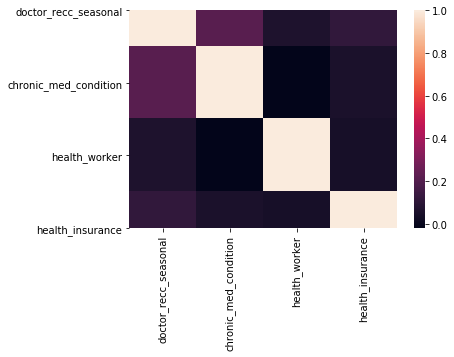

In [14]:
# heatmap shows few correlations due to high number of nulls and categorical columns

corr = X_train.corr()
sns.heatmap(corr)


In [15]:
# show per cent nulls by column
# about half of data is missing for health_insurance, employment_industry, employment_occupation

round((X_train.isna().sum()*100/len(X_train)),2)

doctor_recc_seasonal     8.12000
chronic_med_condition    3.64000
health_worker            3.01000
health_insurance        45.92000
age_group                0.00000
race                     0.00000
sex                      0.00000
marital_status           5.21000
employment_status        5.42000
hhs_geo_region           0.00000
census_msa               0.00000
employment_industry     49.96000
employment_occupation   50.46000
dtype: float64

In [16]:
# look closer at three columns with high null percentages - see if there is an obvious choice to impute

for c in X_train.columns:
    print(X_train[c].value_counts())
    
# most ppl have health insurance, I can create a new column to indicate which rows are missing this info
# employment industry and occupation - when encoded, nulls will be ignored

0.00000    12332
1.00000     6072
Name: doctor_recc_seasonal, dtype: int64
0.00000    13845
1.00000     5455
Name: chronic_med_condition, dtype: int64
0.00000    17231
1.00000     2196
Name: health_worker, dtype: int64
1.00000    9513
0.00000    1319
Name: health_insurance, dtype: int64
65+ Years        5142
55 - 64 Years    4205
18 - 34 Years    3957
45 - 54 Years    3857
35 - 44 Years    2869
Name: age_group, dtype: int64
White                15926
Black                 1598
Hispanic              1284
Other or Multiple     1222
Name: race, dtype: int64
Female    11860
Male       8170
Name: sex, dtype: int64
Married        10143
Not Married     8843
Name: marital_status, dtype: int64
Employed              10160
Not in Labor Force     7715
Unemployed             1070
Name: employment_status, dtype: int64
lzgpxyit    3234
fpwskwrf    2420
qufhixun    2372
kbazzjca    2162
oxchjgsf    2151
bhuqouqj    2096
mlyzmhmf    1663
lrircsnp    1565
atmpeygn    1545
dqpwygqj     822
Name: hhs_geo_

In [17]:
# create new df X_train_plot to contain a numeric age column for plotting

X_train_plot=X_train.copy()
X_train_plot['age_group_num'] = X_train_plot['age_group'].apply(lambda x:1 if (x == '18 - 34 Years')
                                                        else 2 if (x == '35 - 44 Years')
                                                        else 3 if (x == '45 - 54 Years')
                                                        else 4 if (x == '55 - 64 Years')
                                                        else 5)

In [18]:
# concatenate X_train_plot and y_train to create a df for plotting bar graphs

train_to_plot = pd.concat([X_train_plot, y_train], axis=1).drop(columns='age_group')
train_to_plot

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,race,sex,marital_status,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation,age_group_num,seasonal_vaccine
2476,nan,0.00000,0.00000,nan,Black,Male,Not Married,NaN,lzgpxyit,"MSA, Principle City",NaN,NaN,3,0
12746,0.00000,0.00000,0.00000,0.00000,White,Female,Married,Employed,atmpeygn,Non-MSA,pxcmvdjn,xgwztkwe,3,1
14949,0.00000,0.00000,0.00000,nan,White,Female,Not Married,Employed,bhuqouqj,"MSA, Principle City",wxleyezf,xtkaffoo,2,0
22103,0.00000,0.00000,0.00000,1.00000,White,Female,Married,Employed,atmpeygn,Non-MSA,vjjrobsf,vlluhbov,1,0
23171,0.00000,1.00000,0.00000,nan,White,Male,Not Married,Not in Labor Force,mlyzmhmf,"MSA, Principle City",NaN,NaN,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22449,0.00000,1.00000,0.00000,1.00000,White,Female,Married,Employed,bhuqouqj,"MSA, Not Principle City",mfikgejo,hfxkjkmi,1,0
25371,1.00000,1.00000,0.00000,1.00000,Other or Multiple,Male,Married,Not in Labor Force,mlyzmhmf,"MSA, Not Principle City",NaN,NaN,5,1
21082,nan,0.00000,0.00000,0.00000,White,Female,Not Married,Unemployed,atmpeygn,"MSA, Principle City",NaN,NaN,1,1
3778,nan,0.00000,0.00000,1.00000,White,Female,Married,Not in Labor Force,lzgpxyit,"MSA, Not Principle City",NaN,NaN,3,0


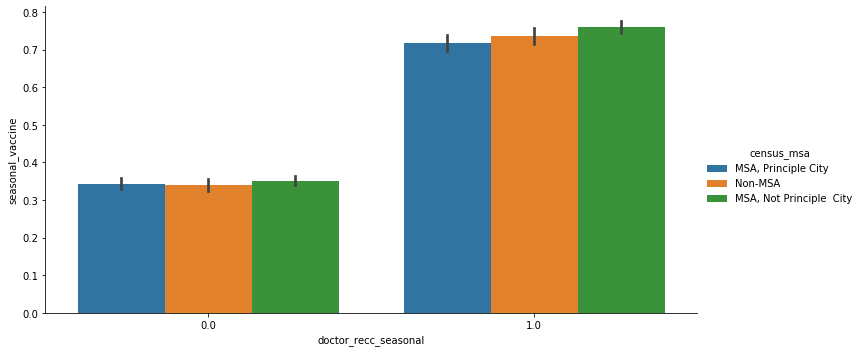

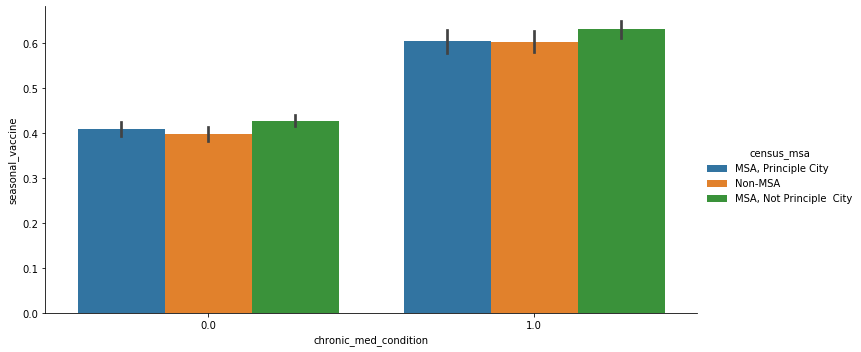

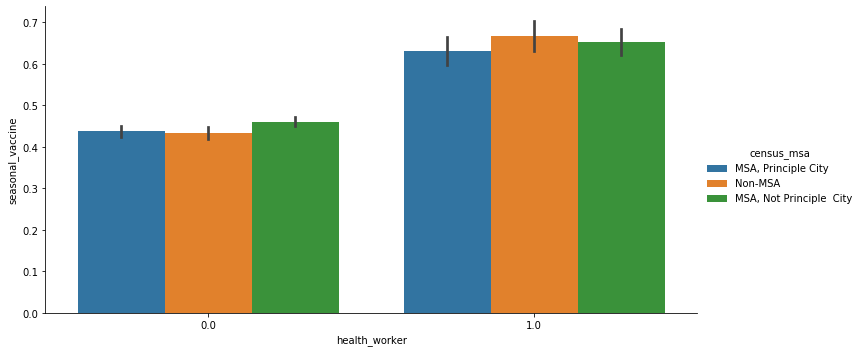

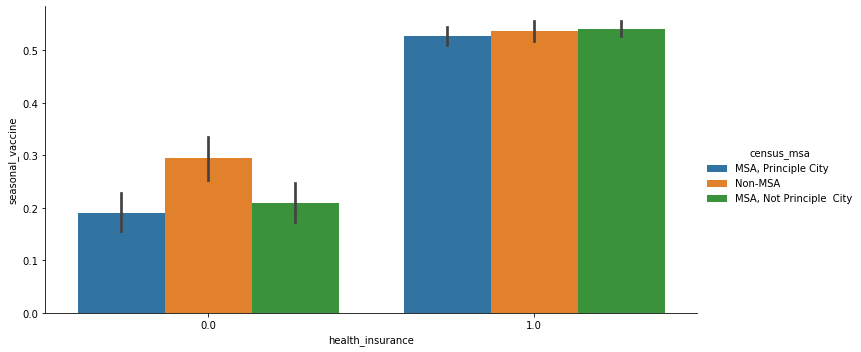

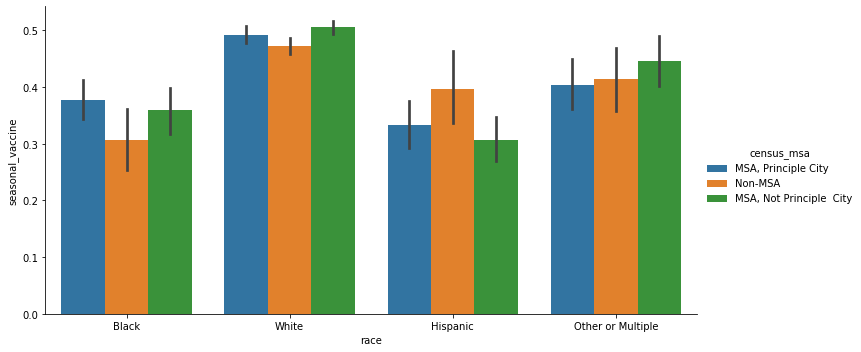

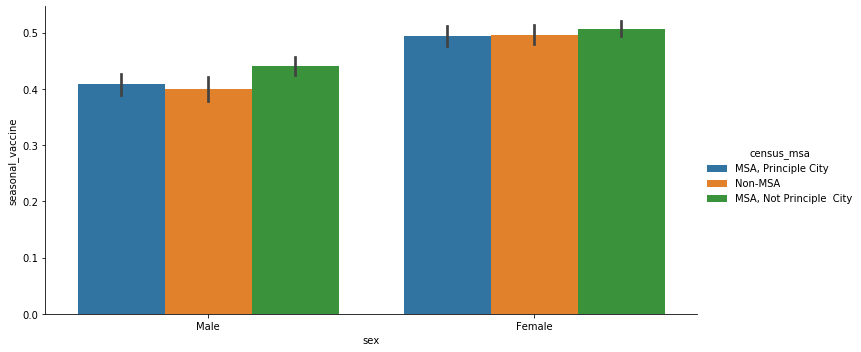

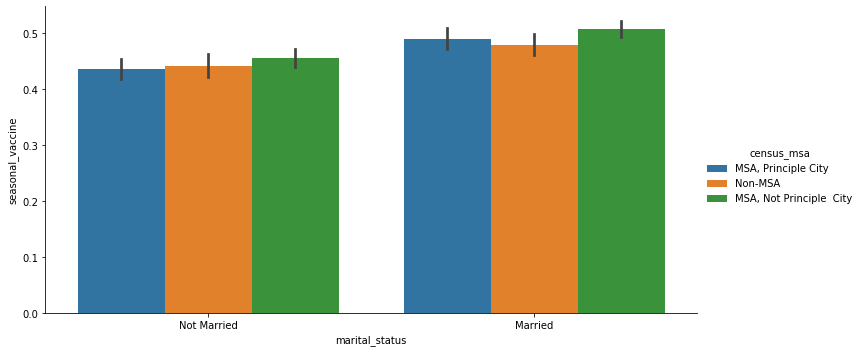

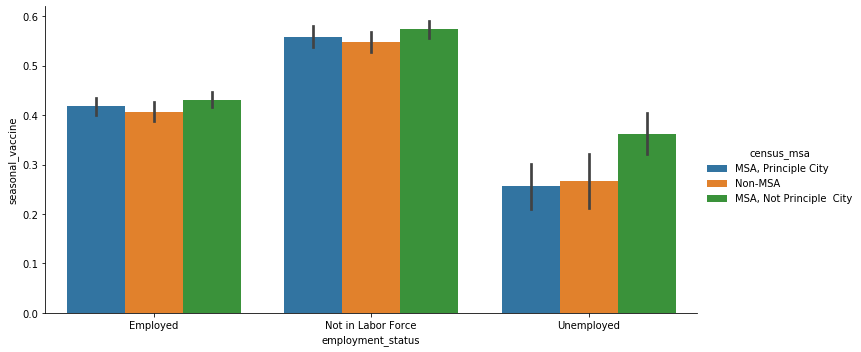

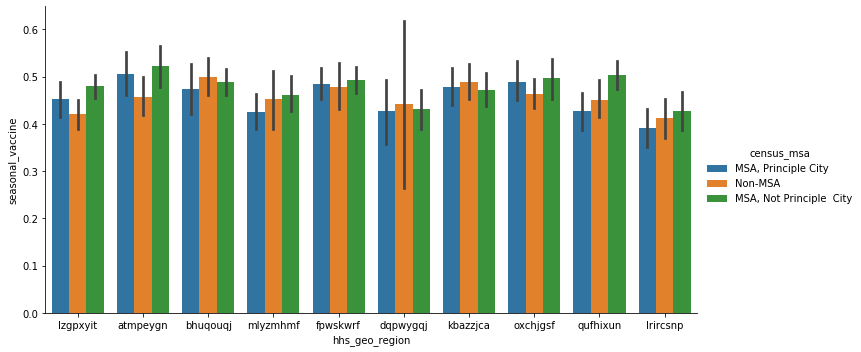

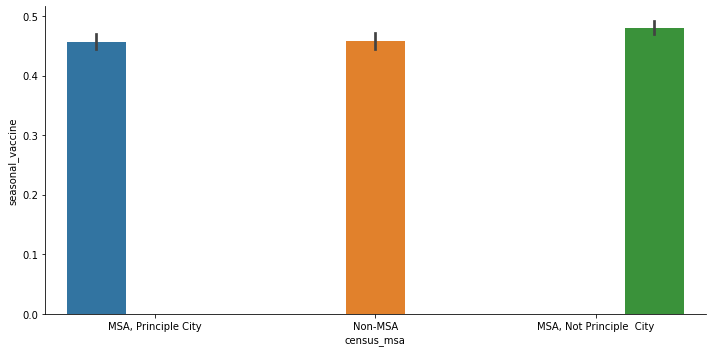

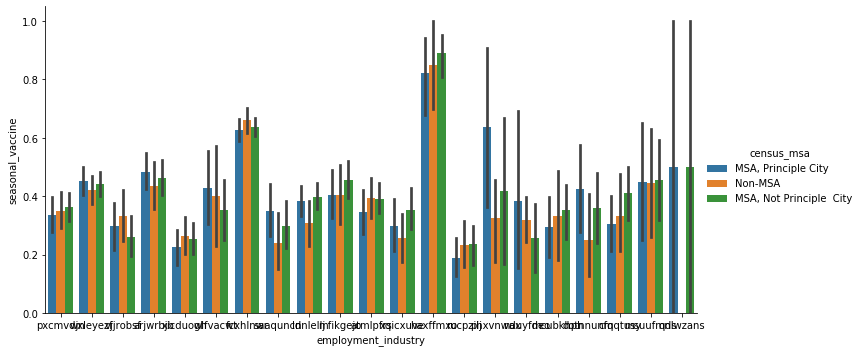

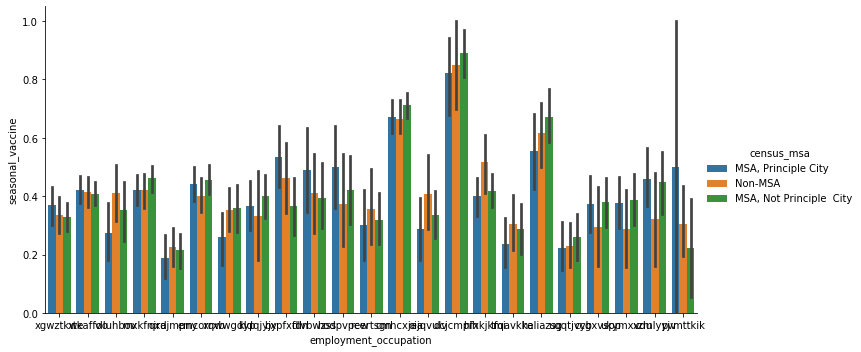

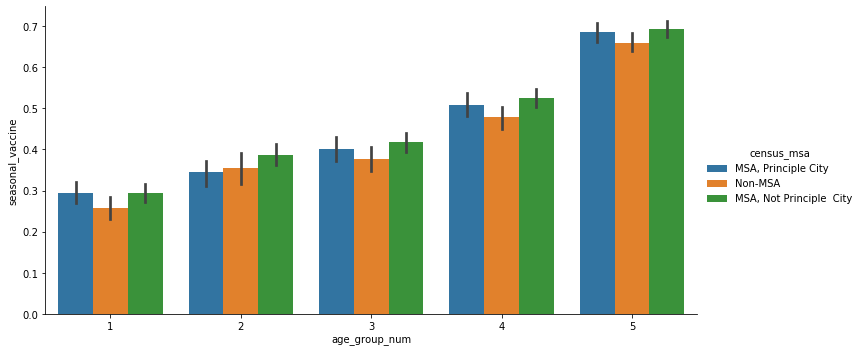

In [19]:
# plot bar graphs for each variable vs target
# test different hues to get sense of variable interactions
# interesting interactions:
# sex and marital status
# census_msa and race (what's going on?)
# sex and race
# also sex and employment status --> probably due to age

for c in train_to_plot.drop(columns=['seasonal_vaccine']).columns:
    sns.catplot(x=c, y="seasonal_vaccine", kind="bar", hue='census_msa', data=train_to_plot, height=5, aspect=2)

['haxffmxo' 'fcxhlnwr' 'qnlwzans' 'arjwrbjb' 'msuufmds' 'wxleyezf'
 'mfikgejo' 'phxvnwax' 'wlfvacwt' 'atmlpfrs' 'ldnlellj' 'cfqqtusy'
 'dotnnunm' 'pxcmvdjn' 'mcubkhph' 'xqicxuve' 'nduyfdeo' 'saaquncn'
 'vjjrobsf' 'xicduogh' 'rucpziij']


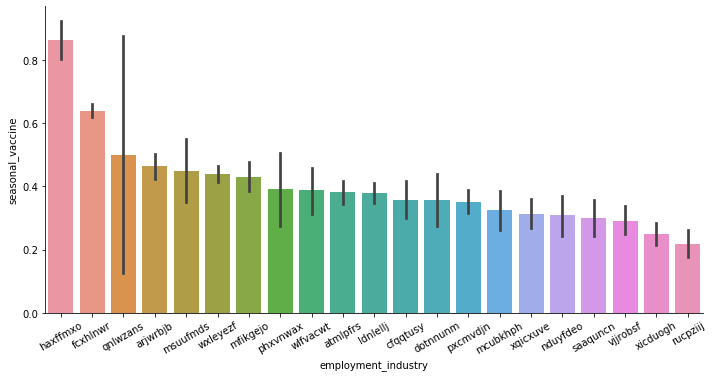

In [20]:
# arrange employment_industry values by probability - see if there are groupings
# reducing number of columns may reduce overfitting

sort_order = train_to_plot.groupby('employment_industry')['seasonal_vaccine'].mean().sort_values(ascending=False).index.values
plot = sns.catplot(data=train_to_plot, x='employment_industry', y='seasonal_vaccine', kind='bar', height=5, aspect=2, order=sort_order)
plot.set_xticklabels(rotation=30)
print(sort_order)

In [21]:
# create employment_industry groupings

ind_cat_1 = ['haxffmxo'] # clearly number one
ind_cat_2 = ['fcxhlnwr'] # clearly number two
ind_cat_3 = ['qnlwzans'] # clearly an oddball
ind_cat_4 = ['rucpziij','xicduogh'] # on the bottom
ind_cat_5 = ['msuufmds','arjwrbjb','wxleyezf','mfikgejo','wlfvacwt','phxvnwax','ldnlellj','dotnnunm','atmlpfrs'] # mid upper
ind_cat_6 = ['cfqqtusy','pxcmvdjn','xqicxuve','vjjrobsf','nduyfdeo','mcubkhph','saaquncn'] # mid lower

In [22]:
# create columns for employment_industry categories

ind_cat_list = [ind_cat_1, ind_cat_2, ind_cat_3, ind_cat_4, ind_cat_5, ind_cat_6]

for n, ind_cat in enumerate(ind_cat_list):
    X_train['ind_cat_'+str(n+1)] = X_train['employment_industry'].map(lambda x: 1 if x in ind_cat else 0)
    
X_train.head(100)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,age_group,race,sex,marital_status,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6
2476,nan,0.00000,0.00000,nan,45 - 54 Years,Black,Male,Not Married,NaN,lzgpxyit,"MSA, Principle City",NaN,NaN,0,0,0,0,0,0
12746,0.00000,0.00000,0.00000,0.00000,45 - 54 Years,White,Female,Married,Employed,atmpeygn,Non-MSA,pxcmvdjn,xgwztkwe,0,0,0,0,0,1
14949,0.00000,0.00000,0.00000,nan,35 - 44 Years,White,Female,Not Married,Employed,bhuqouqj,"MSA, Principle City",wxleyezf,xtkaffoo,0,0,0,0,1,0
22103,0.00000,0.00000,0.00000,1.00000,18 - 34 Years,White,Female,Married,Employed,atmpeygn,Non-MSA,vjjrobsf,vlluhbov,0,0,0,0,0,1
23171,0.00000,1.00000,0.00000,nan,55 - 64 Years,White,Male,Not Married,Not in Labor Force,mlyzmhmf,"MSA, Principle City",NaN,NaN,0,0,0,0,0,0
10835,0.00000,0.00000,0.00000,1.00000,45 - 54 Years,White,Male,Married,Employed,fpwskwrf,"MSA, Not Principle City",arjwrbjb,mxkfnird,0,0,0,0,1,0
22628,0.00000,1.00000,0.00000,nan,45 - 54 Years,White,Female,Not Married,Not in Labor Force,lzgpxyit,Non-MSA,NaN,NaN,0,0,0,0,0,0
10,0.00000,1.00000,0.00000,0.00000,45 - 54 Years,White,Male,Married,Employed,lzgpxyit,"MSA, Not Principle City",xicduogh,qxajmpny,0,0,0,1,0,0
10709,0.00000,0.00000,0.00000,nan,18 - 34 Years,Black,Male,Not Married,Not in Labor Force,lzgpxyit,"MSA, Principle City",NaN,NaN,0,0,0,0,0,0
18883,1.00000,0.00000,0.00000,1.00000,65+ Years,White,Female,Not Married,Not in Labor Force,dqpwygqj,"MSA, Not Principle City",NaN,NaN,0,0,0,0,0,0


['dcjcmpih' 'cmhcxjea' 'haliazsg' 'bxpfxfdn' 'mxkfnird' 'emcorrxb'
 'xzmlyyjv' 'hodpvpew' 'hfxkjkmi' 'dlvbwzss' 'xtkaffoo' 'kldqjyjy'
 'ukymxvdu' 'ccgxvspp' 'vlluhbov' 'xgwztkwe' 'oijqvulv' 'xqwwgdyp'
 'rcertsgn' 'pvmttkik' 'tfqavkke' 'uqqtjvyb' 'qxajmpny']


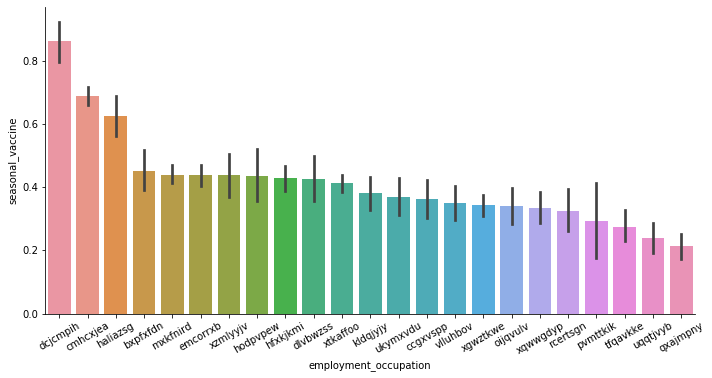

In [23]:
# arrange employment_occupation values by probability - see if there are groupings

sort_order = train_to_plot.groupby('employment_occupation')['seasonal_vaccine'].mean().sort_values(ascending=False).index.values
plot = sns.catplot(data=train_to_plot, x='employment_occupation', y='seasonal_vaccine', kind='bar', height=5, aspect=2, order=sort_order)
plot.set_xticklabels(rotation=30)
print(sort_order)

In [24]:
# create employment_occupation categories

occ_cat_1 = ['dcjcmpih'] # clearly number one
occ_cat_2 = ['cmhcxjea'] # clearly number two
occ_cat_3 = ['haliazsg'] # clearly number three
occ_cat_4 = ['tfqavkke','uqqtjvyb','qxajmpny'] # on the bottom
occ_cat_5 = ['xzmlyyjv', 'hodpvpew', 'emcorrxb','bxpfxfdn', 'mxkfnird', 'xtkaffoo', 'hfxkjkmi', 'dlvbwzss', 'kldqjyjy'] # mid upper
occ_cat_6 = ['vlluhbov','ukymxvdu','oijqvulv','xgwztkwe','rcertsgn','ccgxvspp','pvmttkik', 'xqwwgdyp'] # mid lower

In [25]:
# create categories for employment_occupation to reduce dimensionality

occ_cat_list = [occ_cat_1, occ_cat_2, occ_cat_3, occ_cat_4, occ_cat_5, occ_cat_6]

for n, occ_cat in enumerate(occ_cat_list):
    X_train['occ_cat_'+str(n+1)] = X_train['employment_occupation'].map(lambda x: 1 if x in occ_cat else 0)
    
X_train.head(100)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,age_group,race,sex,marital_status,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6,occ_cat_1,occ_cat_2,occ_cat_3,occ_cat_4,occ_cat_5,occ_cat_6
2476,nan,0.00000,0.00000,nan,45 - 54 Years,Black,Male,Not Married,NaN,lzgpxyit,"MSA, Principle City",NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
12746,0.00000,0.00000,0.00000,0.00000,45 - 54 Years,White,Female,Married,Employed,atmpeygn,Non-MSA,pxcmvdjn,xgwztkwe,0,0,0,0,0,1,0,0,0,0,0,1
14949,0.00000,0.00000,0.00000,nan,35 - 44 Years,White,Female,Not Married,Employed,bhuqouqj,"MSA, Principle City",wxleyezf,xtkaffoo,0,0,0,0,1,0,0,0,0,0,1,0
22103,0.00000,0.00000,0.00000,1.00000,18 - 34 Years,White,Female,Married,Employed,atmpeygn,Non-MSA,vjjrobsf,vlluhbov,0,0,0,0,0,1,0,0,0,0,0,1
23171,0.00000,1.00000,0.00000,nan,55 - 64 Years,White,Male,Not Married,Not in Labor Force,mlyzmhmf,"MSA, Principle City",NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
10835,0.00000,0.00000,0.00000,1.00000,45 - 54 Years,White,Male,Married,Employed,fpwskwrf,"MSA, Not Principle City",arjwrbjb,mxkfnird,0,0,0,0,1,0,0,0,0,0,1,0
22628,0.00000,1.00000,0.00000,nan,45 - 54 Years,White,Female,Not Married,Not in Labor Force,lzgpxyit,Non-MSA,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
10,0.00000,1.00000,0.00000,0.00000,45 - 54 Years,White,Male,Married,Employed,lzgpxyit,"MSA, Not Principle City",xicduogh,qxajmpny,0,0,0,1,0,0,0,0,0,1,0,0
10709,0.00000,0.00000,0.00000,nan,18 - 34 Years,Black,Male,Not Married,Not in Labor Force,lzgpxyit,"MSA, Principle City",NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
18883,1.00000,0.00000,0.00000,1.00000,65+ Years,White,Female,Not Married,Not in Labor Force,dqpwygqj,"MSA, Not Principle City",NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
# drop old 'employment_industry' and 'employment_occupation' columns

X_train.drop(columns=['employment_industry', 'employment_occupation'], inplace=True)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [27]:
# encode remaining categorical columns in X_train
# do not drop all firsts, but drop sex_Female and race_Other to reduce columns

X_train_enc = pd.get_dummies(X_train, drop_first=False).drop(columns=['sex_Female','race_Other or Multiple'])

# experimented with removing more firsts, but did not improve model
# scores when dropped 1 column - female
# ROC Scores
# Train: 0.7817244813917411
# Test: 0.7748843069535213

# scores when dropped 2 columns - female and other race
# ROC Scores
# Train: 0.7803958619891809
# Test: 0.7782699504901386

# scores when 5 columns dropped
# ROC Scores
# Train: 0.780485435457886
# Test: 0.772152694994743
# worse!

In [28]:
# 4 columns still have nulls
X_train_enc.isna().sum()[:4]

doctor_recc_seasonal     1626
chronic_med_condition     730
health_worker             603
health_insurance         9198
dtype: int64

In [29]:
# cannot delete rows with missing health_insurance, since about 50%
# check for overlaps in nulls in other 3 rows, may be possible to delete these rows

X_train_delete_nulls = X_train.loc[(X_train['doctor_recc_seasonal'].notnull()
                                      & X_train['chronic_med_condition'].notnull()
                                      & X_train['health_worker'].notnull())]
X_train_delete_nulls

# if we delete all nulls in all 3 columns, we lose 2295 rows, 11% of data
# so let's not delete them
# Instead, fill them with 0s and create columns to indicate if they had nulls
# also tested filling them with the dummy value 0.5, but did not improve model

print('If I deleted rows with nulls in doctor_recc_seasonal, chronic_med_condition, health_worker:')
print('Number of rows deleted:', len(X_train) - len(X_train_delete_nulls))
print('Per cent of rows deleted:', round(((len(X_train) - len(X_train_delete_nulls))/len(X_train)*100),2), '%')


If I deleted rows with nulls in doctor_recc_seasonal, chronic_med_condition, health_worker:
Number of rows deleted: 2245
Per cent of rows deleted: 11.21 %


In [30]:
# create new columns to capture null info prior to filling nans with 0

X_train_nans=X_train_enc.copy()
X_train_nans['null_doctor_recc'] = X_train_nans['doctor_recc_seasonal'].apply(lambda x:1 if pd.isnull(x) else 0)
X_train_nans['null_chronic'] = X_train_nans['doctor_recc_seasonal'].apply(lambda x:1 if pd.isnull(x) else 0)
X_train_nans['null_health_worker'] = X_train_nans['health_worker'].apply(lambda x:1 if pd.isnull(x) else 0)
X_train_nans['null_health_ins'] = X_train_nans['health_insurance'].apply(lambda x:1 if pd.isnull(x) else 0)
X_train_nans.head(100)

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6,occ_cat_1,occ_cat_2,occ_cat_3,occ_cat_4,occ_cat_5,occ_cat_6,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,race_Black,race_Hispanic,race_White,sex_Male,marital_status_Married,marital_status_Not Married,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA,null_doctor_recc,null_chronic,null_health_worker,null_health_ins
2476,nan,0.00000,0.00000,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1
12746,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
14949,0.00000,0.00000,0.00000,nan,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
22103,0.00000,0.00000,0.00000,1.00000,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
23171,0.00000,1.00000,0.00000,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
10835,0.00000,0.00000,0.00000,1.00000,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
22628,0.00000,1.00000,0.00000,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
10,0.00000,1.00000,0.00000,0.00000,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
10709,0.00000,0.00000,0.00000,nan,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
18883,1.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [31]:
# fill nans with 0

X_train_nans.fillna(value=0, inplace=True)
X_train_nans.isna().sum().sum() #0
X_train_nans.shape
X_train_nans

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6,occ_cat_1,occ_cat_2,occ_cat_3,occ_cat_4,occ_cat_5,occ_cat_6,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,race_Black,race_Hispanic,race_White,sex_Male,marital_status_Married,marital_status_Not Married,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA,null_doctor_recc,null_chronic,null_health_worker,null_health_ins
2476,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1
12746,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
14949,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
22103,0.00000,0.00000,0.00000,1.00000,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
23171,0.00000,1.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22449,0.00000,1.00000,0.00000,1.00000,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
25371,1.00000,1.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
21082,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0
3778,0.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0


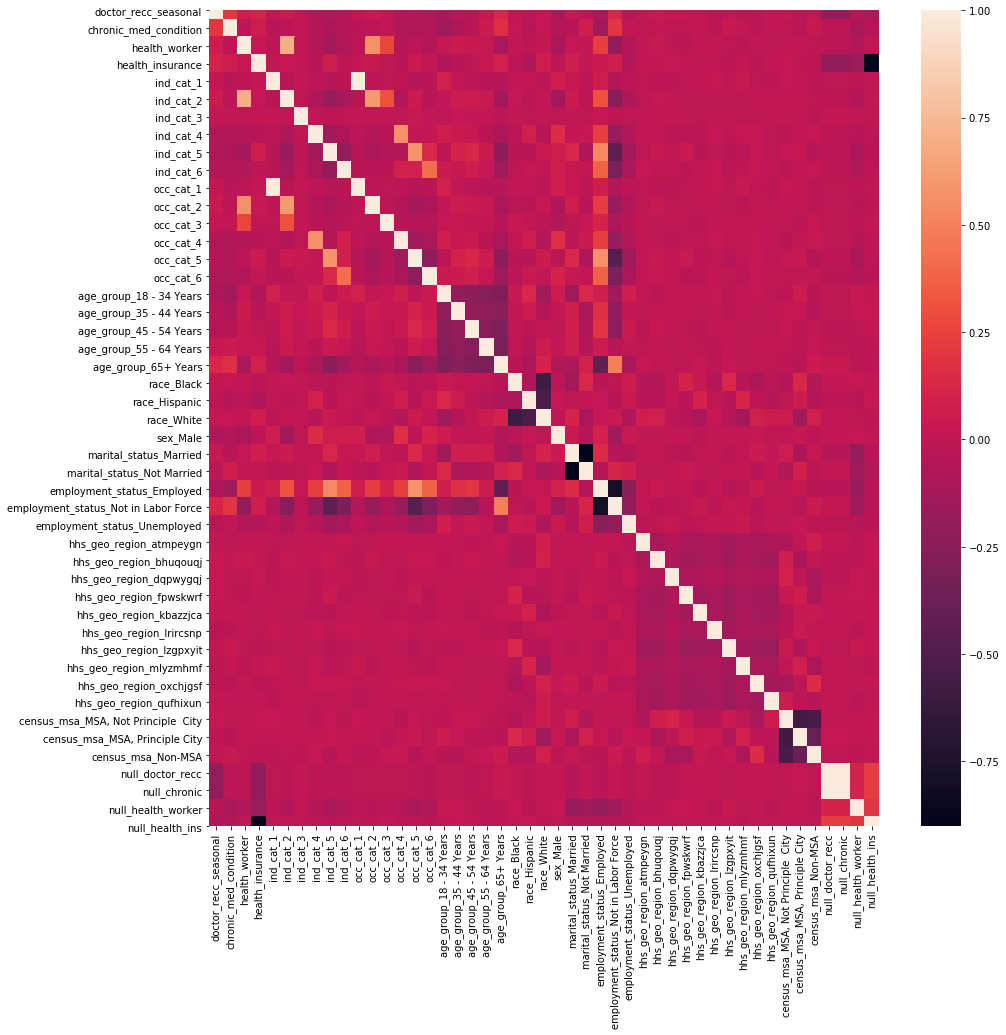

In [32]:
corr = X_train_nans.corr()

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr, ax=ax);

# no surprising correlations, except maybe ind_cats and occ_cats

In [33]:
# run X_test thru same steps

# create categories for employment_industry
for n, ind_cat in enumerate(ind_cat_list):
    X_test['ind_cat_'+str(n+1)] = X_test['employment_industry'].map(lambda x: 1 if x in ind_cat else 0)

# create categories for employment_industry
for n, occ_cat in enumerate(occ_cat_list):
    X_test['occ_cat_'+str(n+1)] = X_test['employment_occupation'].map(lambda x: 1 if x in occ_cat else 0)

X_test.drop(columns=['employment_industry','employment_occupation'], inplace=True)

# encode categorical columns
X_test_enc = pd.get_dummies(X_test, drop_first=False).drop(columns=['sex_Female','race_Other or Multiple'])

# create columns to track null values
X_test_nans=X_test_enc.copy()
X_test_nans['null_doctor_recc'] = X_test_nans['doctor_recc_seasonal'].apply(lambda x:1 if pd.isnull(x) else 0)
X_test_nans['null_chronic'] = X_test_nans['doctor_recc_seasonal'].apply(lambda x:1 if pd.isnull(x) else 0)
X_test_nans['null_health_worker'] = X_test_nans['health_worker'].apply(lambda x:1 if pd.isnull(x) else 0)
X_test_nans['null_health_ins'] = X_test_nans['health_insurance'].apply(lambda x:1 if pd.isnull(x) else 0)

# fill remaining nulls with 0
X_test_nans.fillna(value=0, inplace=True)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pan

In [34]:
X_test_nans

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6,occ_cat_1,occ_cat_2,occ_cat_3,occ_cat_4,occ_cat_5,occ_cat_6,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,race_Black,race_Hispanic,race_White,sex_Male,marital_status_Married,marital_status_Not Married,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA,null_doctor_recc,null_chronic,null_health_worker,null_health_ins
9389,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1
24791,0.00000,0.00000,0.00000,1.00000,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
12819,1.00000,1.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
12352,0.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
21246,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22088,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
3926,1.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
23723,0.00000,1.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
19270,0.00000,0.00000,1.00000,1.00000,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0


ROC Scores
Train: 0.7826229817533836
Test: 0.7685676451254044


Accuracy Scores
Train: 0.7149276085871193
Test: 0.7019619589636064


F1 Scores
Train: 0.6854687672138371
Test: 0.66419169760378
Cross-Validation Scores:
Train:
[0.72216675 0.70244633 0.70644034 0.71892162 0.71467798]
Test:
[0.69835329 0.6758982  0.69513109 0.6988764  0.7011236 ]


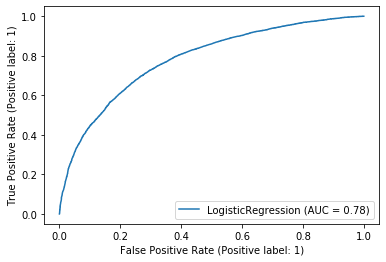

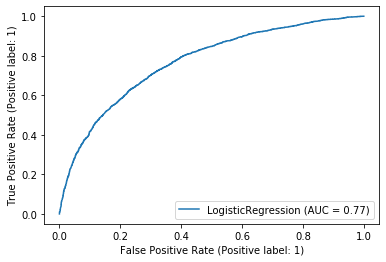

In [35]:
# plot ROC curves
logreg = ut.logreg_predict_score(X_train_nans, X_test_nans, y_train, y_test)
plot_roc_curve(logreg, X_train_nans, y_train)
plot_roc_curve(logreg, X_test_nans, y_test)


In [36]:
# Let's scale it!  # test Standard Scaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_nans)
X_test_scaled = scaler.transform(X_test_nans)

In [37]:
ut.logreg_predict_score(X_train_scaled, X_test_scaled, y_train, y_test)

# no change - makes sense since everything is already on a 0-1 scale

ROC Scores
Train: 0.7826396625842384
Test: 0.7685201488817615


Accuracy Scores
Train: 0.7147279081377933
Test: 0.7015126553841545


F1 Scores
Train: 0.6969343375411053
Test: 0.6777687954729185
Cross-Validation Scores:
Train:
[0.71667499 0.70718922 0.70619071 0.72316525 0.71642536]
Test:
[0.6991018  0.68338323 0.69513109 0.69588015 0.70786517]


LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [38]:
# Let's scale it!  # test MixMax Scaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_nans)
X_test_scaled = scaler.transform(X_test_nans)

ut.logreg_predict_score(X_train_scaled, X_test_scaled, y_train, y_test)

# no change - makes sense since everything is already on a 0-1 scale

ROC Scores
Train: 0.7826229817533836
Test: 0.7685676451254044


Accuracy Scores
Train: 0.7149276085871193
Test: 0.7019619589636064


F1 Scores
Train: 0.6854687672138371
Test: 0.66419169760378
Cross-Validation Scores:
Train:
[0.72216675 0.70244633 0.70644034 0.71892162 0.71467798]
Test:
[0.69835329 0.6758982  0.69513109 0.6988764  0.7011236 ]


LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [39]:
# add interaction term for man & married

X_train_inter = X_train_nans.copy()
X_train_inter['man_Married'] = X_train_inter['sex_Male'] * X_train_inter['marital_status_Married']
X_train_inter

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6,occ_cat_1,occ_cat_2,occ_cat_3,occ_cat_4,occ_cat_5,occ_cat_6,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,race_Black,race_Hispanic,race_White,sex_Male,marital_status_Married,marital_status_Not Married,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA,null_doctor_recc,null_chronic,null_health_worker,null_health_ins,man_Married
2476,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1,0
12746,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
14949,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
22103,0.00000,0.00000,0.00000,1.00000,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
23171,0.00000,1.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22449,0.00000,1.00000,0.00000,1.00000,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
25371,1.00000,1.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1
21082,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0
3778,0.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0


In [40]:
# do same steps on X_test
X_test_inter = X_test_nans.copy()
X_test_inter['man_Married'] = X_test_inter['sex_Male'] * X_test_inter['marital_status_Married']
X_test_inter

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6,occ_cat_1,occ_cat_2,occ_cat_3,occ_cat_4,occ_cat_5,occ_cat_6,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,race_Black,race_Hispanic,race_White,sex_Male,marital_status_Married,marital_status_Not Married,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA,null_doctor_recc,null_chronic,null_health_worker,null_health_ins,man_Married
9389,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1
24791,0.00000,0.00000,0.00000,1.00000,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
12819,1.00000,1.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
12352,0.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
21246,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22088,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3926,1.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
23723,0.00000,1.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
19270,0.00000,0.00000,1.00000,1.00000,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1


In [41]:
# test version with interaction term

ut.logreg_predict_score(X_train_inter, X_test_inter, y_train, y_test)

# no change

ROC Scores
Train: 0.782627637567518
Test: 0.7684867389765372


Accuracy Scores
Train: 0.7154268597104343
Test: 0.70121311966452


F1 Scores
Train: 0.6860541969596827
Test: 0.6629498226051698
Cross-Validation Scores:
Train:
[0.720669   0.70319521 0.70718922 0.71942087 0.71517723]
Test:
[0.69760479 0.6758982  0.69513109 0.69812734 0.70037453]


LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

ROC Scores
Train: 0.7826233922660278
Test: 0.7685689092839805


Accuracy Scores
Train: 0.7148776834747879
Test: 0.7019619589636064


F1 Scores
Train: 0.6854310107408428
Test: 0.66419169760378
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


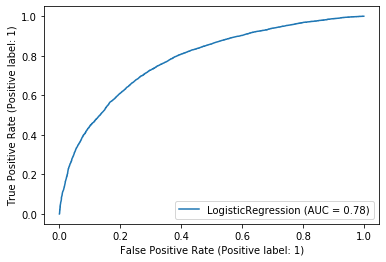

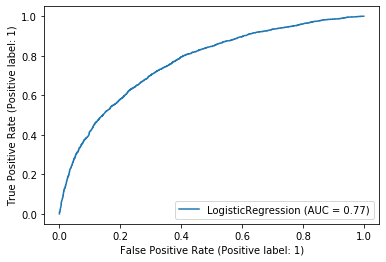

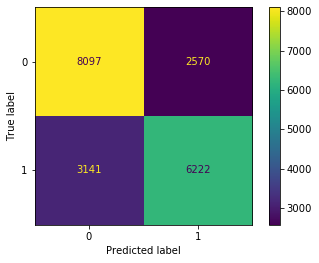

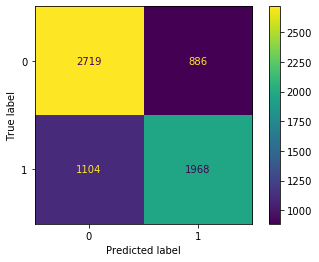

In [42]:
# test fit_intercept=True

# make logistic regression
logreg = LogisticRegression(fit_intercept=True, C=1e12, solver='liblinear')
logreg.fit(X_train_nans, y_train)

# print ROC scores
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, logreg)

# no change

LogisticRegression(C=10, fit_intercept=False, solver='liblinear')
ROC Scores
Train: 0.782620628815058
Test: 0.7685621370058947


Accuracy Scores
Train: 0.7149775336994508
Test: 0.7019619589636064


F1 Scores
Train: 0.685506527846637
Test: 0.66419169760378
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


LogisticRegression(C=100, fit_intercept=False, solver='liblinear')
ROC Scores
Train: 0.7826228015283205
Test: 0.7685678257194868


Accuracy Scores
Train: 0.7149276085871193
Test: 0.7019619589636064


F1 Scores
Train: 0.6854687672138371
Test: 0.66419169760378
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


LogisticRegression(C=1000, fit_intercept=False, solver='liblinear')
ROC Scores
Train: 0.7826231519659436
Test: 0.7685673742342811


Accuracy Scores
Train: 0.7149276085871193
Test: 0.7019619589636064


F1 Scores
Train: 0.6854687672138371
Test: 0.66419169760378
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confu

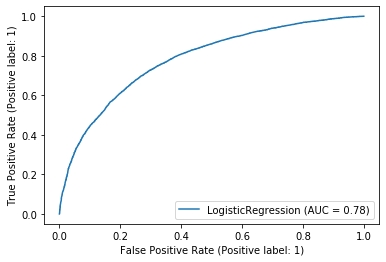

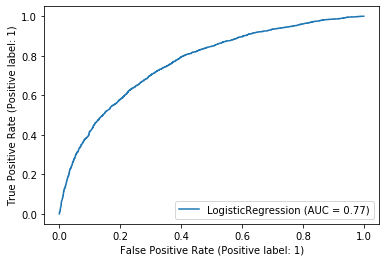

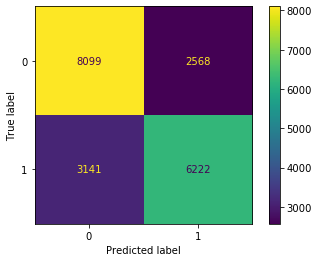

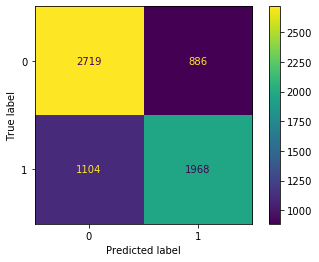

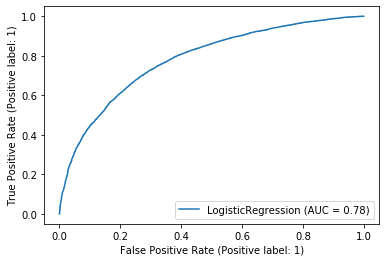

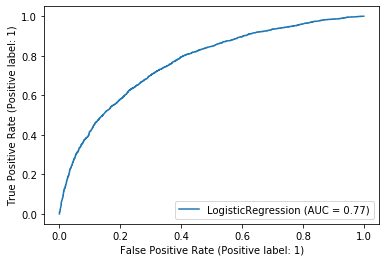

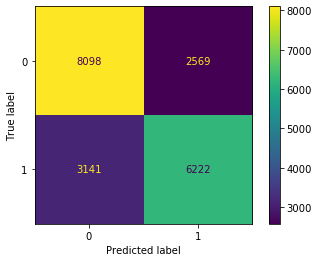

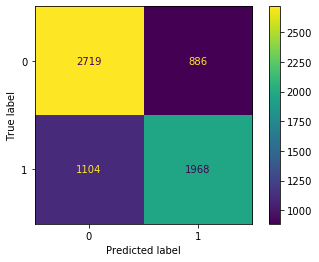

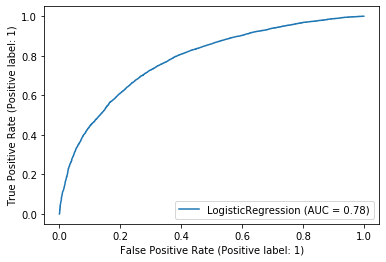

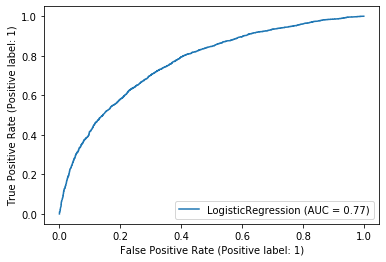

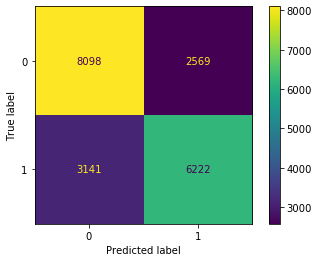

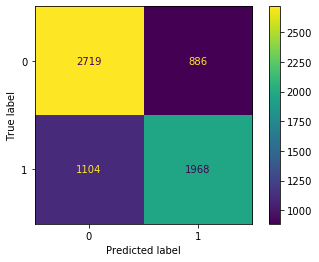

In [43]:
# test C

c_list = [10,100,1000]

# make logreg and score
for c in c_list:
    # make logistic regression
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    logreg.fit(X_train_nans, y_train)
    print(logreg)
    ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, logreg)
    print('\n')
    
# no change

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='newton-cg')
ROC Scores
Train: 0.782623202028461
Test: 0.7685681869076514


Accuracy Scores
Train: 0.7149276085871193
Test: 0.7019619589636064


F1 Scores
Train: 0.6854687672138371
Test: 0.66419169760378
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:




/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

LogisticRegression(C=1000000000000.0, fit_intercept=False)
ROC Scores
Train: 0.7826188666144395
Test: 0.7685430843302127


Accuracy Scores
Train: 0.7149276085871193
Test: 0.7019619589636064


F1 Scores
Train: 0.6853994490358126
Test: 0.66419169760378
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')
ROC Scores
Train: 0.7826229817533836
Test: 0.7685676451254044


Accuracy Scores
Train: 0.7149276085871193
Test: 0.7019619589636064


F1 Scores
Train: 0.6854687672138371
Test: 0.66419169760378
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='sag')
ROC Scores
Train: 0.7826234122910349
Test: 0.7685656585904994


Accuracy Scores
Train: 0.7148776834747879
Test: 0.7019619589636064


F1 Scores
Train: 0.6854310107408428
Test: 0.66419169760378
Train ROC Curve
Test ROC Curve
Train Confusion Matrix

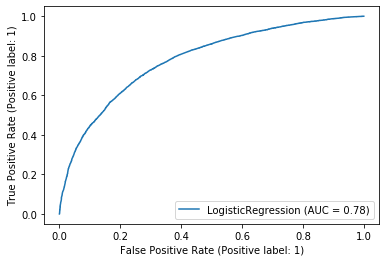

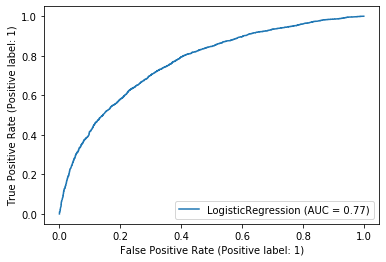

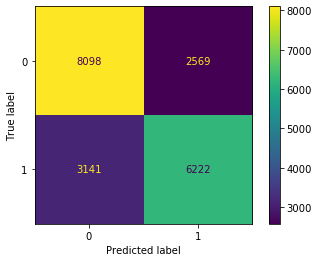

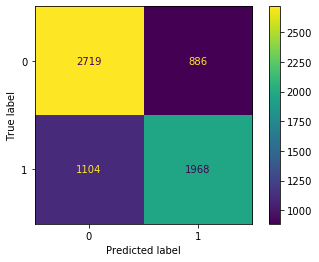

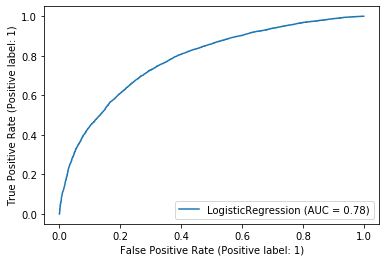

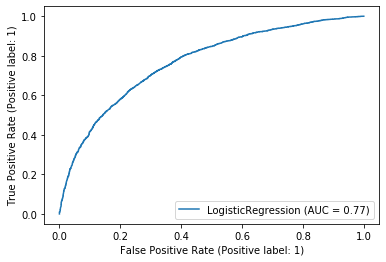

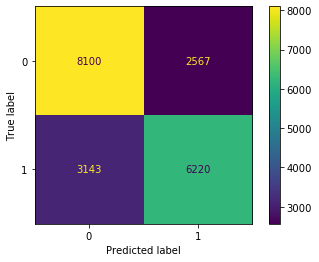

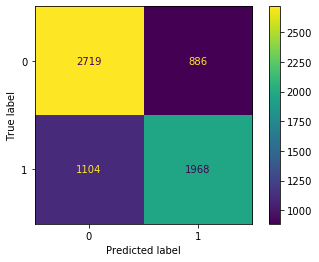

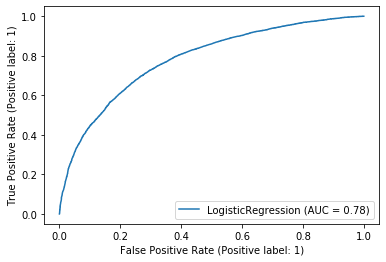

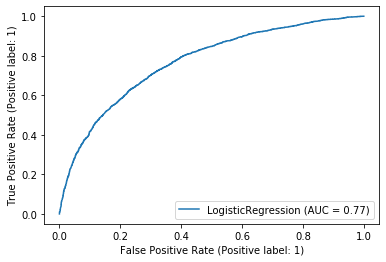

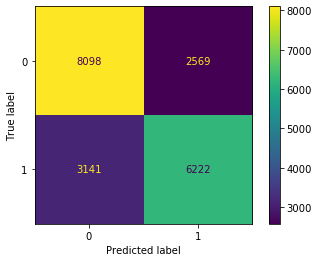

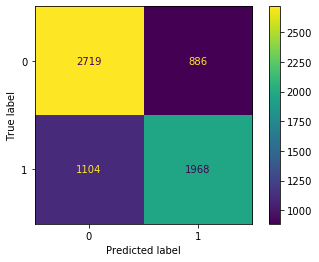

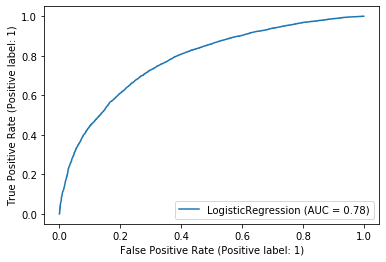

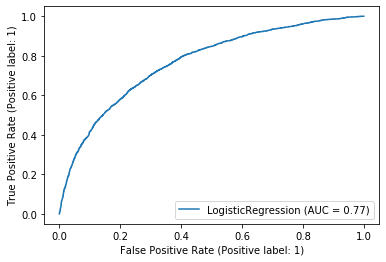

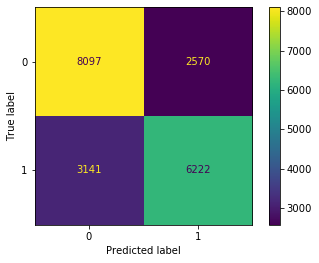

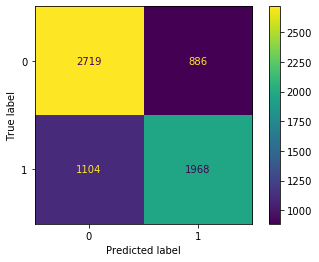

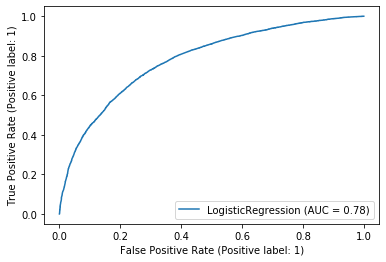

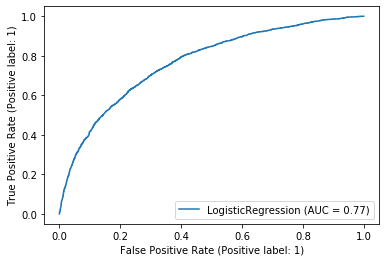

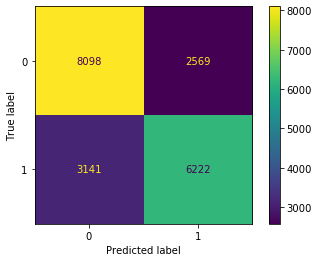

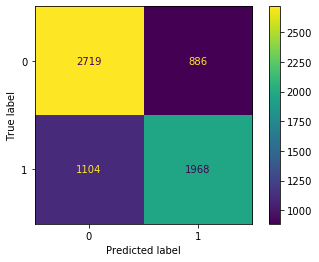

In [44]:
# test solvers

solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

for s in solvers:
    # make logistic regression
    logreg = LogisticRegression(fit_intercept=False, C=1e12, solver=s)
    logreg.fit(X_train_nans, y_train)
    # score
    print(logreg)
    ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, logreg)
    print('\n')
    
    # no change

In [45]:
# no change when using different scalers, adding interaction terms, or changing logreg parameters
# stick with inital df (X_train_nans)
# stick with initial parameters for logreg

best_logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
best_logreg.fit(X_train_nans, y_train)

# cross-validate best_logreg model

print(cross_val_score(best_logreg, X_train_nans, y_train))
print(cross_val_score(best_logreg, X_test_nans, y_test))

[0.72216675 0.70244633 0.70644034 0.71892162 0.71467798]
[0.69835329 0.6758982  0.69513109 0.6988764  0.7011236 ]


In [46]:
# check out coefficients

len(best_logreg.coef_[0])
len(X_train_nans.columns)

coef_dict={}

for n, c in enumerate(X_train_nans.columns):
    coef_dict[c]=round(best_logreg.coef_[0][n],2)

sorted_coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1], reverse=True)}

df = pd.DataFrame.from_dict(sorted_coef_dict, orient='index', columns=['weight'])
df['abs_weight']=np.abs(df['weight'])
df.sort_values(by = 'abs_weight', ascending=False)

,weight,abs_weight
doctor_recc_seasonal,1.51000,1.51000
ind_cat_1,1.51000,1.51000
occ_cat_1,1.51000,1.51000
age_group_18 - 34 Years,-0.95000,0.95000
census_msa_Non-MSA,-0.70000,0.70000
ind_cat_3,0.69000,0.69000
health_worker,0.68000,0.68000
age_group_35 - 44 Years,-0.68000,0.68000
ind_cat_2,0.63000,0.63000
health_insurance,0.60000,0.60000


In [47]:
# run lists below to be sure my coefficients were linking up to the right column labels
# they are

tuple_list = []

for n in range(len(best_logreg.coef_[0])):
    tuple = (n, best_logreg.coef_[0][n])
    tuple_list.append(tuple)
    
tuple_list

[(0, 1.5098268955240548),
 (1, 0.42623455946718686),
 (2, 0.6809542126575686),
 (3, 0.5990397749105605),
 (4, 1.5088456453615242),
 (5, 0.6255681025380704),
 (6, 0.6874464322841808),
 (7, 0.00822474590972653),
 (8, 0.46777158235899097),
 (9, 0.12138984777781718),
 (10, 1.5088456453615242),
 (11, 0.19021367743355497),
 (12, 0.08706886220478967),
 (13, -0.47244673659558223),
 (14, -0.17813723956425098),
 (15, -0.30438519995713964),
 (16, -0.9481640146305419),
 (17, -0.676751441390536),
 (18, -0.4913816166343001),
 (19, -0.16691882143720307),
 (20, 0.5604673341836129),
 (21, -0.5350458477620803),
 (22, -0.17598331740891043),
 (23, 0.04977009621127988),
 (24, -0.07819908772819482),
 (25, -0.029561227917520593),
 (26, -0.20689376668680387),
 (27, -0.26270425120743385),
 (28, -0.05708864878739888),
 (29, -0.3421126765669248),
 (30, -0.04161463044791853),
 (31, -0.1807929204679337),
 (32, -0.4005175707081301),
 (33, -0.04923391673484293),
 (34, -0.08966040161993899),
 (35, -0.3478084412652464

In [48]:
col_list = []

for n in range(len(best_logreg.coef_[0])):
    tuple = (n, X_train_nans.columns[n])
    col_list.append(tuple)
    
col_list

[(0, 'doctor_recc_seasonal'),
 (1, 'chronic_med_condition'),
 (2, 'health_worker'),
 (3, 'health_insurance'),
 (4, 'ind_cat_1'),
 (5, 'ind_cat_2'),
 (6, 'ind_cat_3'),
 (7, 'ind_cat_4'),
 (8, 'ind_cat_5'),
 (9, 'ind_cat_6'),
 (10, 'occ_cat_1'),
 (11, 'occ_cat_2'),
 (12, 'occ_cat_3'),
 (13, 'occ_cat_4'),
 (14, 'occ_cat_5'),
 (15, 'occ_cat_6'),
 (16, 'age_group_18 - 34 Years'),
 (17, 'age_group_35 - 44 Years'),
 (18, 'age_group_45 - 54 Years'),
 (19, 'age_group_55 - 64 Years'),
 (20, 'age_group_65+ Years'),
 (21, 'race_Black'),
 (22, 'race_Hispanic'),
 (23, 'race_White'),
 (24, 'sex_Male'),
 (25, 'marital_status_Married'),
 (26, 'marital_status_Not Married'),
 (27, 'employment_status_Employed'),
 (28, 'employment_status_Not in Labor Force'),
 (29, 'employment_status_Unemployed'),
 (30, 'hhs_geo_region_atmpeygn'),
 (31, 'hhs_geo_region_bhuqouqj'),
 (32, 'hhs_geo_region_dqpwygqj'),
 (33, 'hhs_geo_region_fpwskwrf'),
 (34, 'hhs_geo_region_kbazzjca'),
 (35, 'hhs_geo_region_lrircsnp'),
 (36, 'h

In [49]:
# import eli5
# eli5.show_weights(best_logreg)

ROC Scores
Train: 0.9832981529003604
Test: 0.6341710641325704


Accuracy Scores
Train: 0.9143285072391413
Test: 0.6248315111577055


F1 Scores
Train: 0.9052875593332597
Test: 0.5838179099518193
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


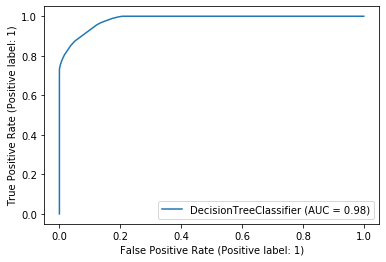

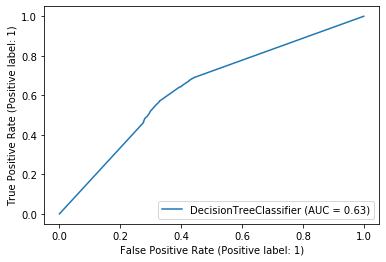

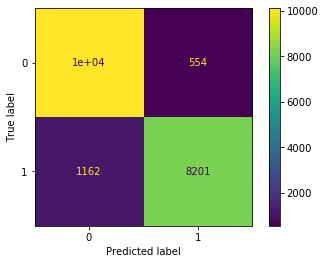

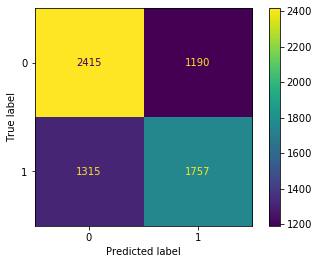

In [50]:
# let's do another model!

tree = DecisionTreeClassifier()

ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, tree)

# yikes, that's really overfit!  let's prune the tree

ROC Scores
Train: 0.7743221507586456
Test: 0.7525338704201341


Accuracy Scores
Train: 0.7163754368447329
Test: 0.6913284409165793


F1 Scores
Train: 0.69573134807991
Test: 0.6659101961420004
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


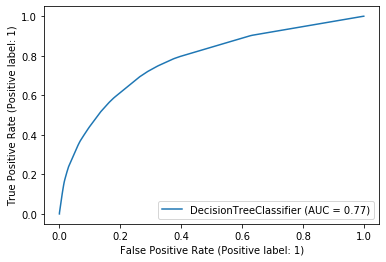

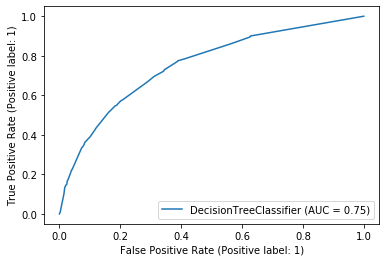

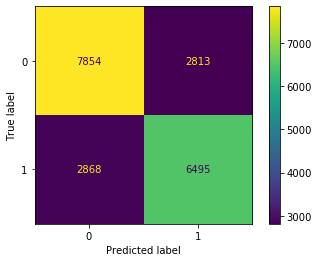

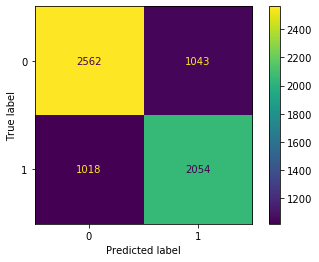

In [51]:
tree = DecisionTreeClassifier(max_depth=6, min_samples_split=10, min_samples_leaf=5, max_features=40, criterion='gini')

ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, tree)

# better, but not better than logreg

In [52]:
def order_features(weights, X_train):
    
    coef_dict = {}

    for n, c in enumerate(X_train.columns):
        coef_dict[c]=round(weights[n],4)

    sorted_coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1], reverse=True)}
    df = pd.DataFrame.from_dict(sorted_coef_dict, orient='index', columns=['weight'])
    df['abs_weight']=np.abs(df['weight'])
    weights_df = df.sort_values(by = 'abs_weight', ascending=False)
    
    return weights_df

In [53]:
tree.feature_importances_

array([5.61486843e-01, 1.78333282e-02, 8.06342320e-02, 1.13942614e-02,
       0.00000000e+00, 1.40744127e-02, 0.00000000e+00, 0.00000000e+00,
       1.29118527e-02, 2.86957057e-03, 2.63543534e-02, 2.99821597e-03,
       0.00000000e+00, 2.95318189e-03, 3.46613399e-04, 0.00000000e+00,
       1.10995113e-02, 0.00000000e+00, 0.00000000e+00, 3.15802117e-02,
       1.85594219e-01, 1.90129798e-02, 0.00000000e+00, 2.22870640e-03,
       7.13615821e-04, 3.46690901e-03, 8.65155054e-04, 0.00000000e+00,
       0.00000000e+00, 2.23367611e-03, 1.27852053e-03, 3.10762926e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.21654583e-03,
       9.54546115e-04, 0.00000000e+00, 1.03869786e-03, 3.59928515e-04,
       3.33020717e-04, 8.09606439e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.04652122e-03])

In [54]:
order_features(tree.feature_importances_, X_train_nans)

,weight,abs_weight
doctor_recc_seasonal,0.56150,0.56150
age_group_65+ Years,0.18560,0.18560
health_worker,0.08060,0.08060
age_group_55 - 64 Years,0.03160,0.03160
occ_cat_1,0.02640,0.02640
race_Black,0.01900,0.01900
chronic_med_condition,0.01780,0.01780
ind_cat_2,0.01410,0.01410
ind_cat_5,0.01290,0.01290
health_insurance,0.01140,0.01140


In [55]:
tree_param_grid = {'criterion': ['gini', 'entropy'],
                 'max_depth': [None, 4, 6, 8],
                 'min_samples_leaf': [10, 12, 14],
                 'min_samples_split': [8, 10, 12],
                  'max_features': [30, 37, 45]}
                 
tree_grid_search = GridSearchCV(tree, tree_param_grid, cv=3)
tree_grid_search.fit(X_train_nans, y_train)

print(f"Training Accuracy: {tree_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {tree_grid_search.best_params_}")

Training Accuracy: 71.12%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_features': 37, 'min_samples_leaf': 10, 'min_samples_split': 10}


ROC Scores
Train: 0.7735461116487657
Test: 0.7528649896700186


Accuracy Scores
Train: 0.7150773839241138
Test: 0.6944735659727422


F1 Scores
Train: 0.6935838926174498
Test: 0.6686159844054581
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


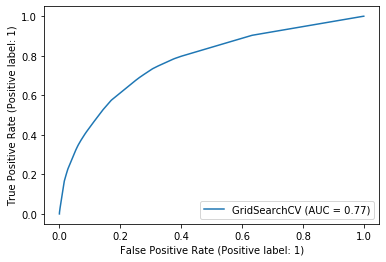

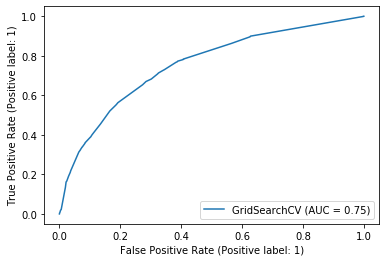

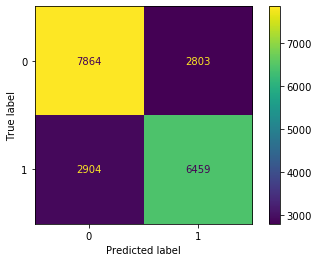

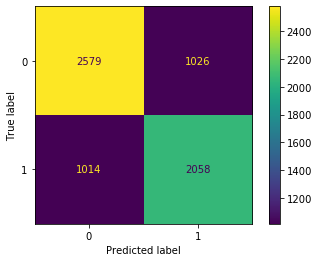

In [56]:
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, tree_grid_search)

In [57]:
tree_grid_search.best_estimator_.feature_importances_

array([5.36412963e-01, 1.77427199e-02, 8.17039429e-02, 1.18157669e-02,
       2.86463755e-02, 1.20042514e-02, 0.00000000e+00, 6.05475739e-04,
       1.69236920e-02, 1.77844149e-03, 0.00000000e+00, 6.46826742e-03,
       0.00000000e+00, 1.90109872e-03, 0.00000000e+00, 1.08350459e-03,
       1.14094336e-02, 0.00000000e+00, 0.00000000e+00, 3.63449994e-02,
       1.94777918e-01, 5.99504411e-03, 0.00000000e+00, 1.07447099e-02,
       2.19188503e-03, 2.67893901e-03, 2.69186995e-03, 0.00000000e+00,
       1.93996228e-03, 6.22614544e-04, 8.87333905e-04, 0.00000000e+00,
       2.04795903e-03, 0.00000000e+00, 8.51867918e-04, 2.01451614e-03,
       1.04376381e-03, 9.08604354e-04, 9.23179181e-04, 5.20156567e-04,
       5.57078280e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.76166515e-03])

In [58]:
order_features(tree_grid_search.best_estimator_.feature_importances_, X_train_nans)

,weight,abs_weight
doctor_recc_seasonal,0.53640,0.53640
age_group_65+ Years,0.19480,0.19480
health_worker,0.08170,0.08170
age_group_55 - 64 Years,0.03630,0.03630
ind_cat_1,0.02860,0.02860
chronic_med_condition,0.01770,0.01770
ind_cat_5,0.01690,0.01690
ind_cat_2,0.01200,0.01200
health_insurance,0.01180,0.01180
age_group_18 - 34 Years,0.01140,0.01140


In [59]:
bagged_tree = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), n_estimators=20)
bagged_tree.fit(X_train_nans, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                  n_estimators=20)

ROC Scores
Train: 0.7756278262731718
Test: 0.7566331303455849


Accuracy Scores
Train: 0.7166250624063905
Test: 0.6949228695521941


F1 Scores
Train: 0.702546902840373
Test: 0.6757918191946523
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


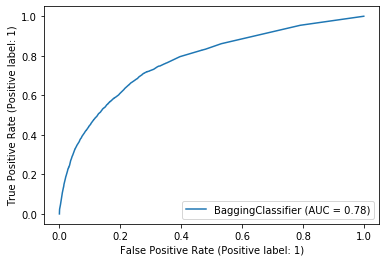

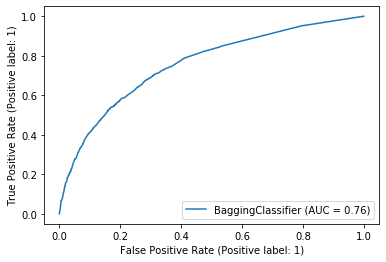

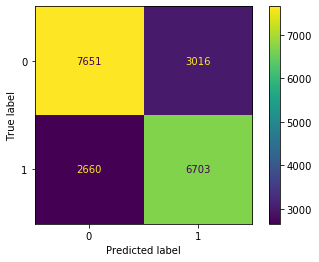

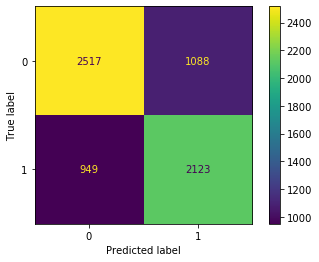

In [60]:
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, bagged_tree)


In [61]:
forest = RandomForestClassifier(n_estimators=100, max_depth=5)
forest.fit(X_train_nans, y_train)

RandomForestClassifier(max_depth=5)

ROC Scores
Train: 0.7803855026118066
Test: 0.7635036064638234


Accuracy Scores
Train: 0.7150274588117823
Test: 0.6977684588887225


F1 Scores
Train: 0.6808320286289421
Test: 0.6577340569877883
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


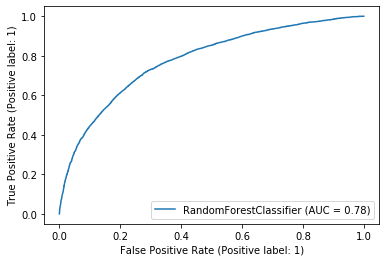

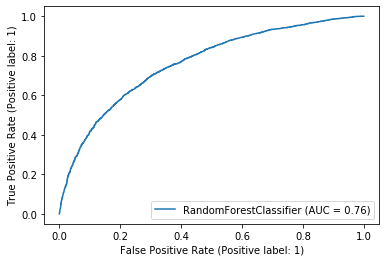

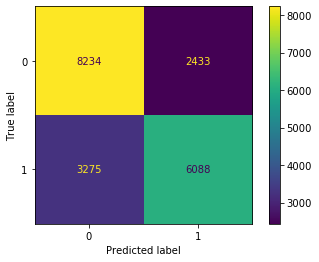

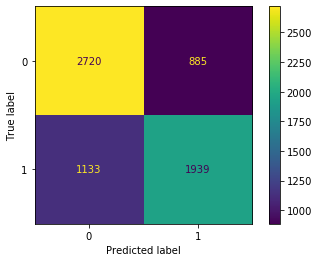

In [62]:
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, forest)

# even better score.  Try grid search with random forest.

In [63]:
rf_param_grid = {'n_estimators': [50, 100],
                 'criterion': ['gini', 'entropy'],
                 'max_depth': [6, 10, 14],
                 'min_samples_leaf': [3, 6, 9],
                'min_samples_split': [5, 10, 15]}
                 
rf_grid_search = GridSearchCV(forest, rf_param_grid, cv=3)
rf_grid_search.fit(X_train_nans, y_train)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")



Training Accuracy: 71.46%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 50}


ROC Scores
Train: 0.8075412344181291
Test: 0.7643773657824781


Accuracy Scores
Train: 0.7340988517224164
Test: 0.7009135839448855


F1 Scores
Train: 0.7091206990715457
Test: 0.6695349991725964
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


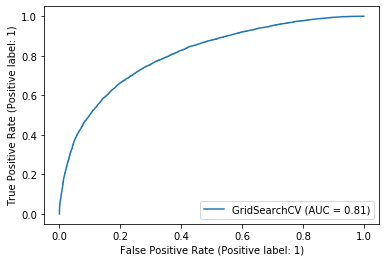

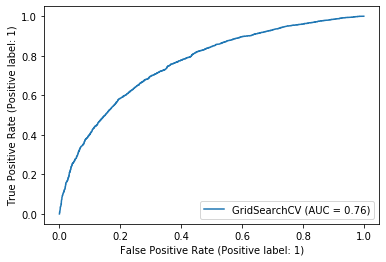

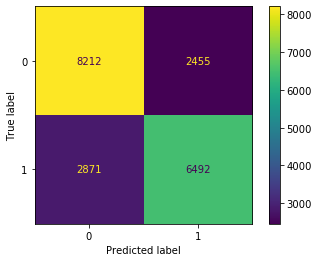

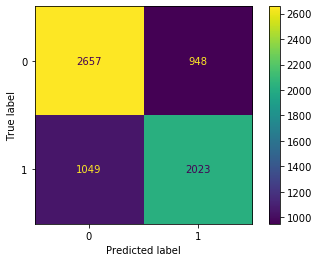

In [64]:
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, rf_grid_search)
# overfit

In [65]:
XGB = XGBClassifier()

# Fit XGBClassifier
XGB.fit(X_train_nans, y_train)


XGBClassifier()

ROC Scores
Train: 0.7885257530751828
Test: 0.7681056403143782


Accuracy Scores
Train: 0.7204193709435847
Test: 0.703309869701962


F1 Scores
Train: 0.6936542669584245
Test: 0.6702180789079407
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


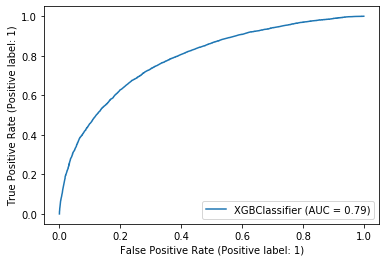

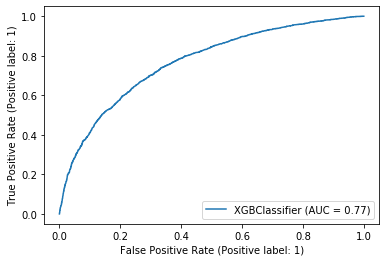

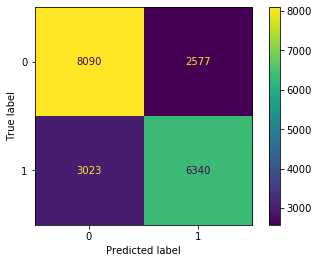

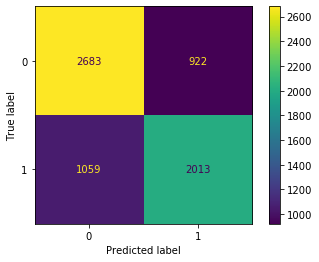

In [66]:
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, XGB)
# less overfit

In [67]:
xgb_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6, 8],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100]}

In [68]:
grid_XGB = GridSearchCV(XGB, xgb_param_grid, cv=None, n_jobs=1)
grid_XGB.fit(X_train_nans, y_train)


GridSearchCV(estimator=XGBClassifier(), n_jobs=1,
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [6, 8],
                         'min_child_weight': [1, 2], 'n_estimators': [100],
                         'subsample': [0.5, 0.7]})

In [69]:
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, grid_XGB)
# overfit
# not better... try different parameters?

KeyboardInterrupt: 

In [ ]:
SVM = SVC(kernel='linear')
SVM.fit(X_train_nans, y_train)

In [ ]:
y_train_pred = SVM.predict(X_train_nans)
y_test_pred = SVM.predict(X_test_nans)

#     print('ROC Scores')
#     print('Train:', roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
#     print('Test:', roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
#     print('\n')
print('Accuracy Scores')
print('Train:', accuracy_score(y_train, y_train_pred))
print('Test:', accuracy_score(y_test, y_test_pred))
print('\n')
print('F1 Scores')
print('Train:', f1_score(y_train, y_train_pred))
print('Test:', f1_score(y_test, y_test_pred))

#     plot_roc_curve(model, X_train, y_train)
#     plot_roc_curve(model, X_test, y_test);

# worse scores for Accuracy and F1